# Hierarchical Clustering
The `linkage()` function from `scipy` implements several clustering functions in python. In the following example we use the data from the previous section to plot the hierarchical
clustering dendrogram using complete, single, and average linkage clustering,
with Euclidean distance as the dissimilarity measure. We begin by
clustering observations using complete linkage:

In [0]:
from scipy.cluster.hierarchy import linkage

hc_complete = linkage(X, "complete")

We could just as easily perform hierarchical clustering with average or single linkage instead:

In [0]:
hc_average = linkage(X, "average")
hc_single = linkage(X, "single")

We can now plot the dendrograms obtained using the usual `dendrogram()` function.
The numbers at the bottom of the plot identify each observation:

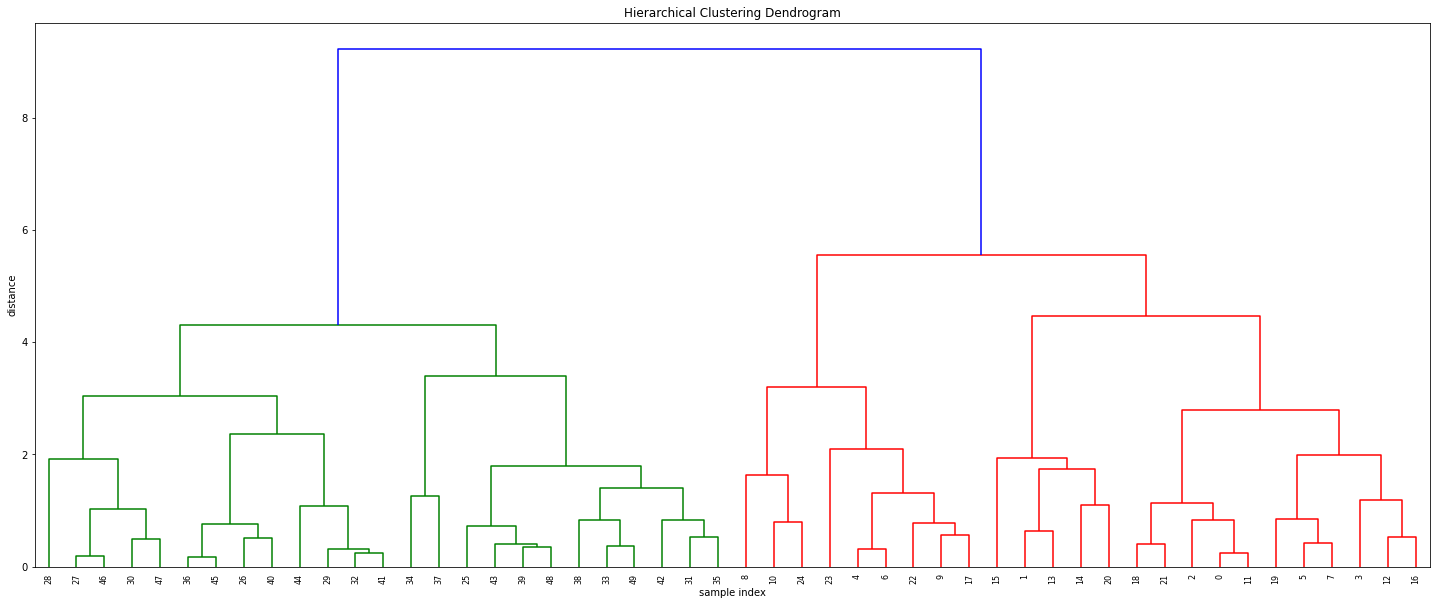

In [0]:
from scipy.cluster.hierarchy import dendrogram

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    hc_complete,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

To determine the cluster labels for each observation associated with a
given cut of the dendrogram, we can use the `cut_tree()` function:

In [0]:
from scipy.cluster.hierarchy import cut_tree
print(cut_tree(hc_complete, n_clusters = 2).T) # Printing transpose just for space

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


For this data, complete and average linkage generally separates the observations
into their correct groups.

# NCI60 Data Example

Unsupervised techniques are often used in the analysis of genomic data. In this portion of the lab, we'll see how hierarchical and K-means clustering compare on the `NCI60` cancer cell line microarray data, which
consists of 6,830 gene expression measurements on 64 cancer cell lines:

In [1]:
# The NCI60 data
nci_labs = pd.read_csv("NCI60_labs.csv", index_col = 0)
nci_data = pd.read_csv("NCI60_data.csv", index_col = 0)

NameError: ignored

Each cell line is labeled with a cancer type. We'll ignore the
cancer types in performing clustering, as these are unsupervised
techniques. After performing clustering, we'll use this column to see the extent to which these cancer types agree with the results of these
unsupervised techniques.

The data has 64 rows and 6,830 columns.

In [0]:
nci_data.shape

Let's take a look at the cancer types for the cell lines:

In [0]:
nci_labs.x.value_counts(sort=True)

# Clustering the Observations of the NCI60 Data
We now proceed to hierarchically cluster the cell lines in the `NCI60` data,
with the goal of finding out whether or not the observations cluster into
distinct types of cancer.

We now perform hierarchical clustering of the observations using complete,
single, and average linkage. We'll use standard Euclidean distance as the dissimilarity
measure:

In [0]:
nci_data.index = nci_labs.x

fig, ax = plt.subplots(3,1, figsize=(15,22))
fig.subplots_adjust(hspace=0.5)

linkages = ['complete', 'single', 'average']
for link, axis in zip(linkages, fig.axes):
    hc = linkage(y = nci_data, method=link, metric='euclidean') 
    axis.set_title("Linkage=%s" % link, size=15)
    axis.set_xlabel('Sample Type', size=15)
    axis.set_ylabel('Distance', size=15)
    dendrogram(hc, ax=axis, labels=nci_data.index, leaf_rotation=90, leaf_font_size=10)

We see that the choice of linkage
certainly does affect the results obtained. Typically, single linkage will tend
to yield trailing clusters: very large clusters onto which individual observations
attach one-by-one. On the other hand, complete and average linkage
tend to yield more balanced, attractive clusters. For this reason, complete
and average linkage are generally preferred to single linkage. Clearly cell
lines within a single cancer type do tend to cluster together, although the
clustering is not perfect. 

Let's use our complete linkage hierarchical clustering
for the analysis. We can cut the dendrogram at the height that will yield a particular
number of clusters, say 4:

In [0]:
nci_hc_complete = linkage(y = nci_data, method="complete", metric='euclidean') 

nci_hc_complete_4_clusters = cut_tree(nci_hc_complete, n_clusters = 4) # Printing transpose just for space

pd.crosstab(index = nci_data.index, 
            columns = nci_hc_complete_4_clusters.T[0], 
            rownames = ['Cancer Type'], 
            colnames = ['Cluster'])

There are some clear patterns. All the leukemia cell lines fall in cluster 2,
while the breast cancer cell lines are spread out over three different clusters.
We can plot the cut on the dendrogram that produces these four clusters by adding an `axhline()`, which draws a horizontal line on top of our plot:

In [0]:
fig, ax = plt.subplots(1,1, figsize = (15,8))
dendrogram(nci_hc_complete, 
           labels = nci_data.index, 
           leaf_font_size = 14, 
           show_leaf_counts = True)  

plt.axhline(y=110, c='k', ls='dashed')
plt.show()

We claimed earlier that K-means clustering and hierarchical
clustering with the dendrogram cut to obtain the same number
of clusters can yield **very** different results. How do these `NCI60` hierarchical
clustering results compare to what we get if we perform K-means clustering
with `K = 4`?

In [0]:
kmean_4 = KMeans(n_clusters = 4, random_state = 123, n_init = 150)    
kmean_4.fit(nci_data)
kmean_4.labels_

We can use a confusion matrix to compare the differences in how the two methods assigned observations to clusters:

In [0]:
pd.crosstab(index = kmean_4.labels_, 
            columns = nci_hc_complete_4_clusters.T[0], 
            rownames = ['K-Means'], 
            colnames = ['Hierarchical'])

We see that the four clusters obtained using hierarchical clustering and Kmeans
clustering are somewhat different. Cluster 0 in K-means clustering is almost
identical to cluster 2 in hierarchical clustering. However, the other clusters
differ: for instance, cluster 2 in K-means clustering contains a portion of
the observations assigned to cluster 0 by hierarchical clustering, as well as
all of the observations assigned to cluster 1 by hierarchical clustering.

To get credit for this lab, use a similar analysis to compare the results of your K-means clustering to the results of your hierarchical clustering with single and average linkage. What differences do you notice? Post your response to Moodle: https://moodle.smith.edu/mod/quiz/view.php?id=267171